# Datasets

In [1]:
import numpy as np
import pandas as pd

# Step 1: Generate x
np.random.seed(42)  # for reproducibility
x = np.random.normal(loc=1, scale=0.05, size=(100, 1))

# Step 2: Generate psi (uniform random in [-1, 1])
psi = 2 * np.random.rand(100, 1) - 1

# Step 3: Compute y
y = 1.3 * (x ** 2) + 4.8 * x + 8 + psi

# Step 4: Concatenate x and y into one table
data = np.hstack((x, y))  # horizontal stack: [x | y]

# Step 5: Create DataFrame with proper column names
columns = ['x1', 'Y']
D1 = pd.DataFrame(data, columns=columns)


In [2]:
import pandas as pd

# Load red wine data
red_df = pd.read_csv('winequality-red.csv', sep=';')

# Load white wine data
white_df = pd.read_csv('winequality-white.csv', sep=';')

# Add a new column to each to mark the wine type
red_df['wine_type'] = 'red'
white_df['wine_type'] = 'white'

# Combine red and white DataFrames
D2 = pd.concat([red_df, white_df], ignore_index=True)

# Apply one-hot encoding to 'wine_type' WITHOUT dropping the first category
D2 = pd.get_dummies(D2, columns=['wine_type'])

D2['wine_type_red'] = D2['wine_type_red'].astype(int)
D2 ['wine_type_white'] = D2['wine_type_white'].astype(int)

## continue with Pre process

In [3]:
def check_df(df):
    print("=== Checking DataFrame ===")
    
    # Check for nulls
    nulls = df.isnull().sum()
    print("\nNull values per column:")
    print(nulls[nulls > 0] if nulls.sum() > 0 else "No nulls found")
    
    # Check for sparse data (defined here as >90% same value)
    print("\nChecking for sparse columns (>=90% same value):")
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True).max()
        if top_freq >= 0.9:
            print(f"Column '{col}' is sparse (top value frequency: {top_freq:.2f})")
    
    # Check if all columns are numeric
    non_numeric = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print("\nNon-numeric columns detected:")
        print(non_numeric)
    else:
        print("\nAll columns are numeric")


In [4]:
check_df(D1)

=== Checking DataFrame ===

Null values per column:
No nulls found

Checking for sparse columns (>=90% same value):

All columns are numeric


In [5]:
check_df(D2)

=== Checking DataFrame ===

Null values per column:
No nulls found

Checking for sparse columns (>=90% same value):

All columns are numeric


# GLMs: Generalized Linear Models with Scikit-Learn (5 points)


### 1

In [6]:
from sklearn.model_selection import train_test_split

# Assuming 'quality' is the target column in D2
X = D2.drop('quality', axis=1)
y = D2['quality']

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5197, 13)
Test shape: (1300, 13)


### 2

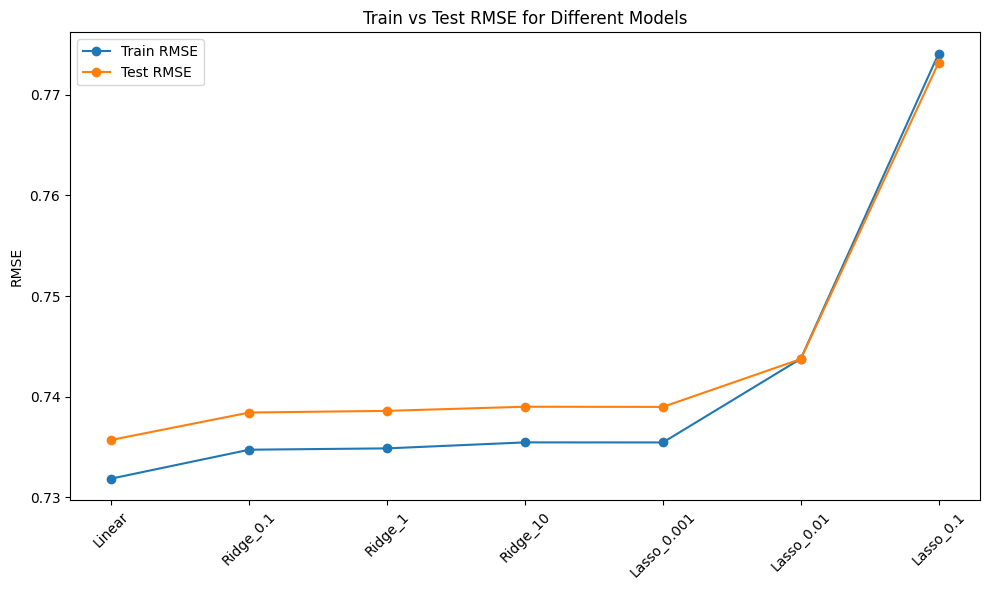

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Initialize models and hyperparameters
models = {
    'Linear': LinearRegression(),
    'Ridge_0.1': Ridge(alpha=0.1),
    'Ridge_1': Ridge(alpha=1),
    'Ridge_10': Ridge(alpha=10),
    'Lasso_0.001': Lasso(alpha=0.001, max_iter=10000),
    'Lasso_0.01': Lasso(alpha=0.01, max_iter=10000),
    'Lasso_0.1': Lasso(alpha=0.1, max_iter=10000)
}

train_rmse = []
test_rmse = []

# Train each model and record RMSE
for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Plotting
x_labels = list(models.keys())
x_pos = np.arange(len(x_labels))

plt.figure(figsize=(10, 6))
plt.plot(x_pos, train_rmse, label='Train RMSE', marker='o')
plt.plot(x_pos, test_rmse, label='Test RMSE', marker='o')
plt.xticks(x_pos, x_labels, rotation=45)
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE for Different Models')
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion: 
In this exercise, we compared three models — Linear Regression, Ridge Regression, and Lasso Regression — by measuring their train and test RMSE on the wine dataset. Linear Regression, which has no regularization, showed low errors on both the training and test sets, with only a small difference between them, indicating the model was not overfitting. When we applied Ridge Regression (which uses L2 regularization), the model’s complexity was slightly reduced, and as we increased the regularization strength, both train and test errors increased slightly, showing that too much regularization can hurt performance if the original model was not overfitting. For Lasso Regression (which uses L1 regularization), the results were similar at low regularization levels, but when the regularization strength became too high, the errors increased sharply. This happened because Lasso tends to push some coefficients exactly to zero, effectively removing features, which can cause underfitting if overdone. Overall, we learned that regularization is useful to control overfitting, but in this case, the original Linear Regression model already generalized well, and adding too much regularization, especially with Lasso, led to underfitting and worse performance.

### 3

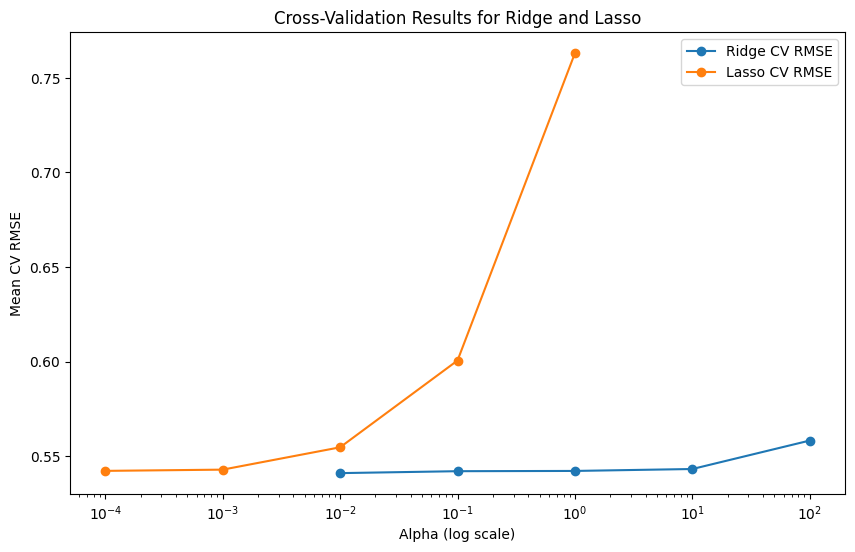

Best Ridge alpha: {'alpha': 0.01}
Best Lasso alpha: {'alpha': 0.0001}


In [8]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define hyperparameter grids
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

# Ridge GridSearchCV
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Lasso GridSearchCV
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Extract results
ridge_scores = -ridge_grid.cv_results_['mean_test_score']
lasso_scores = -lasso_grid.cv_results_['mean_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ridge_params['alpha'], ridge_scores, marker='o', label='Ridge CV RMSE')
plt.plot(lasso_params['alpha'], lasso_scores, marker='o', label='Lasso CV RMSE')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean CV RMSE')
plt.title('Cross-Validation Results for Ridge and Lasso')
plt.legend()
plt.show()

# Best parameters
print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Lasso alpha:", lasso_grid.best_params_)


### short conclusion (wasnt asked): 
This plot shows mean cross-validation RMSE for Ridge and Lasso across different alpha values.
Ridge stays stable across alphas, while Lasso’s error rises sharply when alpha is too large.
In conclusion, too much regularization, especially in Lasso, leads to underfitting and worse performance.

Best Ridge alpha: {'alpha': 0.01}
Best Lasso alpha: {'alpha': 0.0001}

### 4

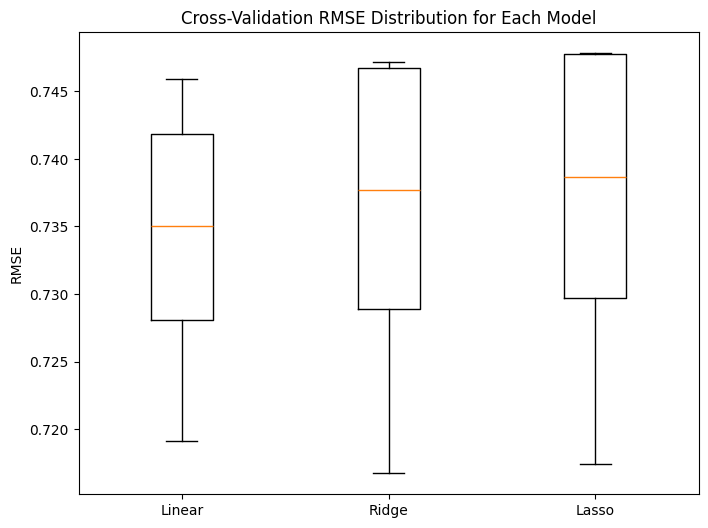

In [9]:
from sklearn.model_selection import cross_val_score

# Best alpha values from GridSearch
best_ridge = Ridge(alpha=ridge_grid.best_params_['alpha'])
best_lasso = Lasso(alpha=lasso_grid.best_params_['alpha'], max_iter=10000)
linear = LinearRegression()  # no hyperparameters

# Get cross_val_score (negative MSE, so we flip sign and take sqrt for RMSE)
ridge_scores = cross_val_score(best_ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lasso_scores = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
linear_scores = cross_val_score(linear, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert to positive RMSE
ridge_rmse = np.sqrt(-ridge_scores)
lasso_rmse = np.sqrt(-lasso_scores)
linear_rmse = np.sqrt(-linear_scores)

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([linear_rmse, ridge_rmse, lasso_rmse], tick_labels=['Linear', 'Ridge', 'Lasso'])
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE Distribution for Each Model')
plt.show()

### Conclusion: 
- This boxplot shows the distribution of cross-validation RMSE scores for Linear, Ridge, and Lasso models using their optimal hyperparameters. All three models have similar median RMSE values, meaning their average prediction error is close. However, Ridge and Lasso display wider boxes (larger interquartile ranges), indicating more variability in performance across the folds compared to Linear Regression. This suggests that in this case, adding regularization did not reduce variability and may have slightly increased it, likely because the dataset was not strongly overfitting to begin with.


- Mathematically, regularization methods like Ridge and Lasso apply penalty terms that shrink coefficients; if the dataset has features that are already stable and useful, these penalties can disturb the balance by unnecessarily reducing or zeroing coefficients. As a result, the models may respond more sensitively to small differences between cross-validation folds, leading to increased variation in performance (higher variance in RMSE) across the splits.

# Polynomial Regression (3 Points)

In [10]:
# 1 (a)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Get x and y from D1
x = D1['x1'].values.reshape(-1, 1)
y = D1['Y'].values.reshape(-1, 1)

# Make sure x is sorted for clean plotting later
sorted_idx = np.argsort(x.flatten())
x_sorted = x[sorted_idx]
y_sorted = y[sorted_idx]

# Define degrees to test
degrees = [1, 2, 7, 10, 16, 100]

# Dictionary to store models and transformers
models = {}

for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(x)
    
    # Fit Linear Regression
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Store model and transformer for later (like prediction and plotting)
    models[degree] = (model, poly)
    
    print(f"Degree {degree}: Model trained")


Degree 1: Model trained
Degree 2: Model trained
Degree 7: Model trained
Degree 10: Model trained
Degree 16: Model trained
Degree 100: Model trained


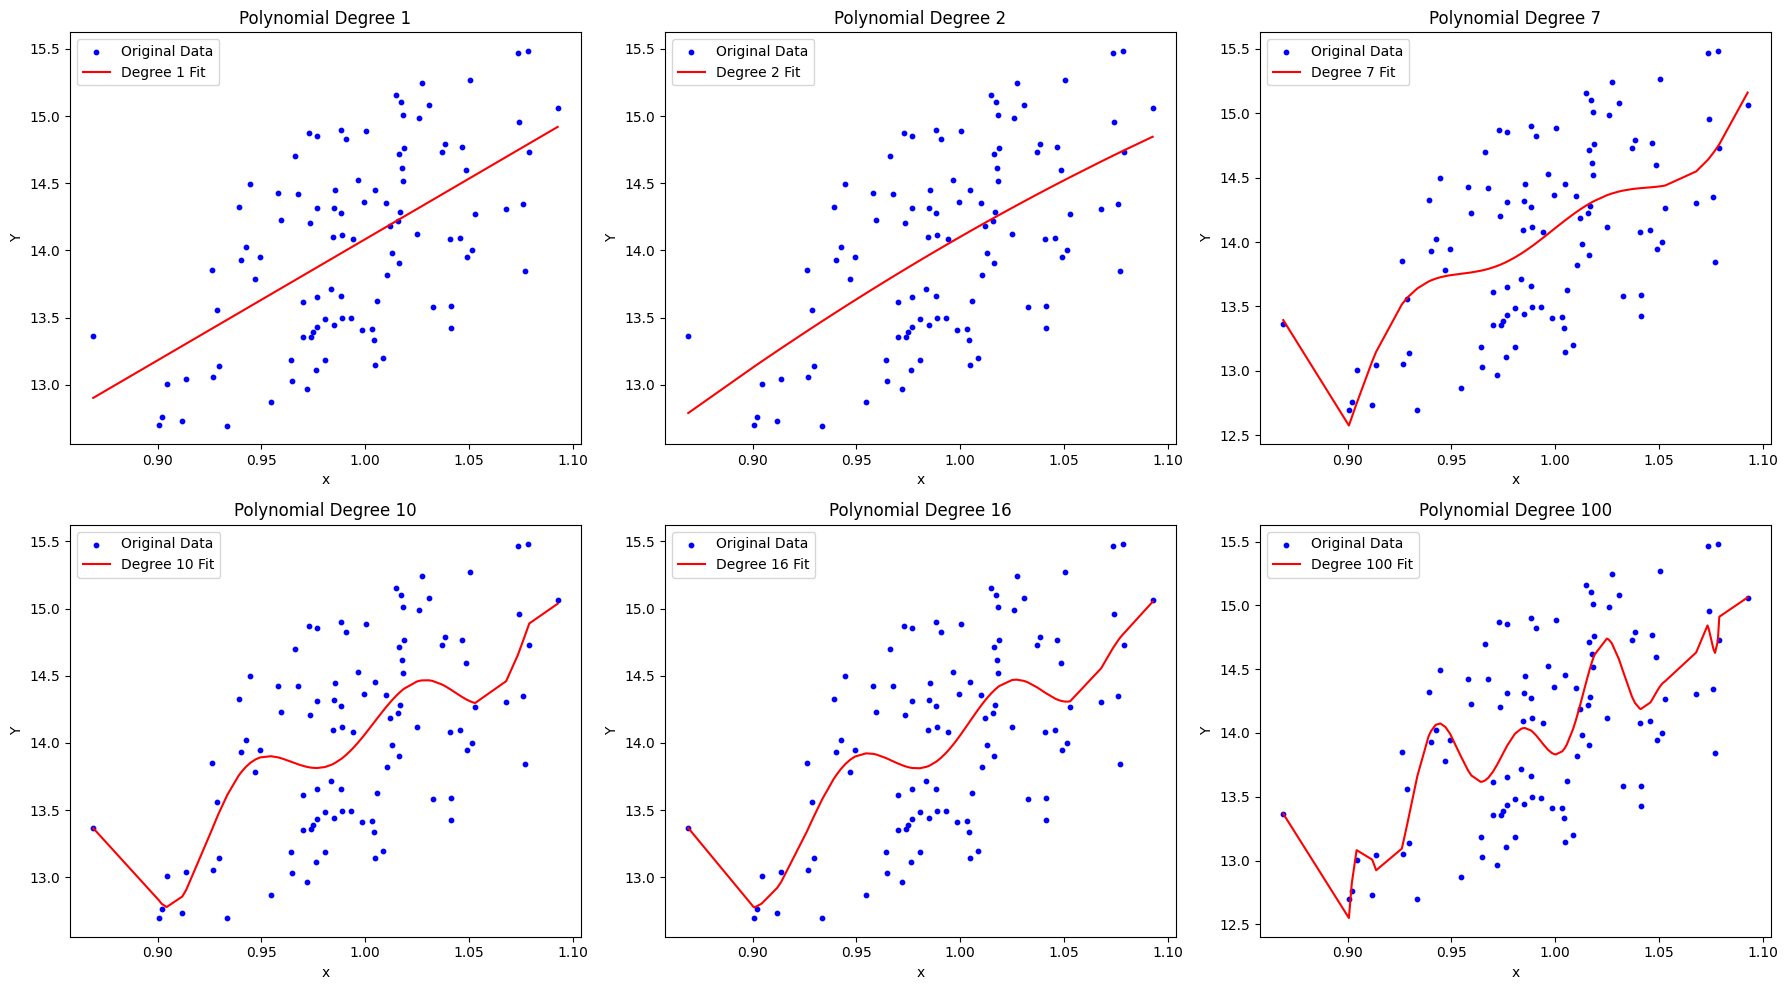

In [11]:
# 1 (b)
# Set up plot
plt.figure(figsize=(18, 10))

# Loop through models and plot
for i, degree in enumerate(degrees, 1):
    model, poly = models[degree]
    
    # Transform sorted x for smooth prediction curve
    X_poly_sorted = poly.transform(x_sorted)
    y_pred = model.predict(X_poly_sorted)
    
    # Plot
    plt.subplot(2, 3, i)
    plt.scatter(x, y, color='blue', label='Original Data', s=10)
    plt.plot(x_sorted, y_pred, color='red', label=f'Degree {degree} Fit')
    plt.title(f'Polynomial Degree {degree}')
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.legend()

plt.tight_layout()
plt.show()


## Conclusion for the diffrent degrees
As we increase the polynomial degree, we observe clear changes in the prediction curves. With degree 1, the model fits a simple straight line, underfitting the data and missing its curvature. At degree 2, the curve bends slightly, capturing some nonlinearity. As we move to degrees 7, 10, and 16, the prediction line becomes more flexible and starts following the data’s fluctuations more closely, reducing bias but increasing variance. By degree 100, the curve wiggles sharply, overfitting the data by chasing even small random noise, which leads to a highly irregular and unstable fit. This progression shows the classic bias-variance tradeoff, where low-degree models underfit and very high-degree models overfit

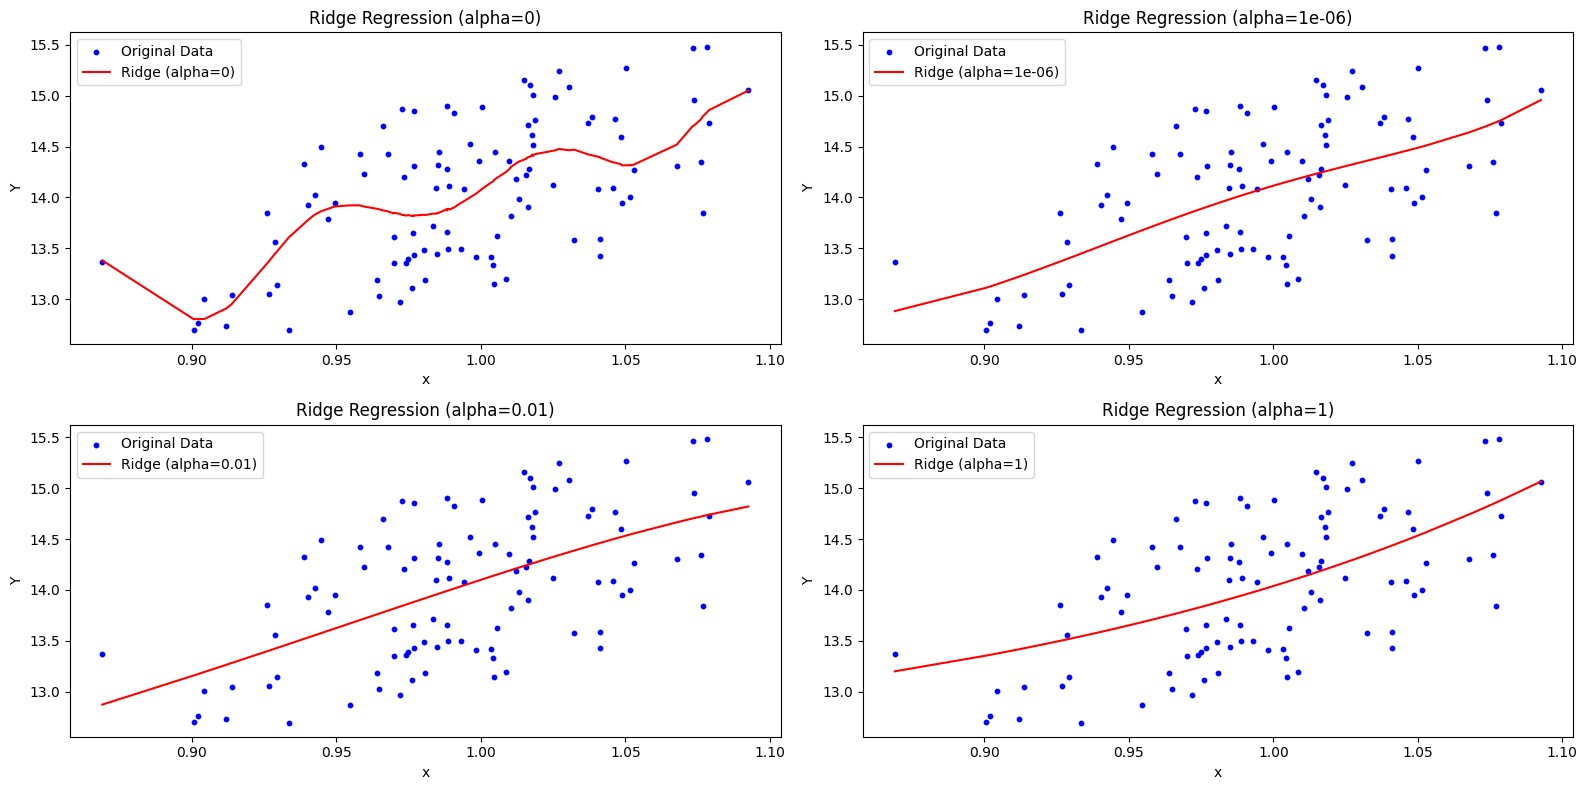

In [12]:
# 2 
# Regulization paramater here called alpha (instead lambda)
from sklearn.linear_model import Ridge
x = D1['x1'].values.reshape(-1, 1)
# 2 (a) Create degree 10 polynomial features
degree = 10
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(x)

# 2 (b) Define Ridge regularization values
alphas = [0, 1e-6, 1e-2, 1]

plt.figure(figsize=(16, 8))
# 2 (c) plot
for i, alpha in enumerate(alphas, 1):
    model = Ridge(alpha=alpha)
    model.fit(X_poly, y)
    
    # Predict on sorted x for smooth curve
    X_poly_sorted = poly.transform(x_sorted)
    y_pred = model.predict(X_poly_sorted)
    
    # Plot
    plt.subplot(2, 2, i)
    plt.scatter(x, y, color='blue', label='Original Data', s=10)
    plt.plot(x_sorted, y_pred, color='red', label=f'Ridge (alpha={alpha})')
    plt.title(f'Ridge Regression (alpha={alpha})')
    plt.xlabel('x')
    plt.ylabel('Y')
    plt.legend()

plt.tight_layout()
plt.show()



## Conclusion 
As we increase the Ridge regularization strength (alpha), we observe a clear shift in the prediction curves. With alpha = 0, the model behaves like a regular high-degree polynomial regression, capturing many wiggles and fluctuations, which suggests overfitting to the noise. As alpha slightly increases the curve becomes smoother, already reducing some of the excessive bending. With moderate alpha values like 0.01, the curve smooths out further, focusing more on the general trend rather than tiny details. Finally, at alpha = 1, the model becomes strongly regularized, producing a nearly straight or gently curved line that prioritizes simplicity but risks underfitting. This progression shows how regularization helps control model complexity by shrinking the effect of higher-degree terms, balancing between overfitting and underfitting.

# Elastic Net using Stochastic Gradient Descent (SGD) 


In [13]:
#Test and Train sets 
import numpy as np
import pandas as pd

# Assume D2 is already loaded as a pandas DataFrame
# Separate features and target
X = D2.drop('quality', axis=1).values  # convert to numpy array
y = D2['quality'].values  # convert to numpy array

# Shuffle indices
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Define split point (80% train, 20% test)
split_point = int(0.8 * len(indices))

# Create train and test sets
X_train = X[indices[:split_point]]
y_train = y[indices[:split_point]]
X_test = X[indices[split_point:]]
y_test = y[indices[split_point:]]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (5197, 13) (5197,)
Test shapes: (1300, 13) (1300,)


In [14]:
# Normalize data
# Compute mean and std from training data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

# Normalize train and test
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std



In [15]:
def elastic_net_sgd(X, y, lr=0.01, lambda1=0.01, lambda2=0.01, epochs=1000):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    
    for epoch in range(epochs):
        for i in range(n_samples):
            xi = X[i]
            yi = y[i]
            
            y_pred = np.dot(xi, weights) + bias
            error = y_pred - yi
            
            # Gradient w.r.t weights
            grad_w = (2 * error * xi) + lambda1 * np.sign(weights) + 2 * lambda2 * weights
            grad_w = np.clip(grad_w, -10, 10)

            # Gradient w.r.t bias
            grad_b = 2 * error
            
            # Update
            weights -= lr * grad_w
            bias -= lr * grad_b
        
        if epoch % 100 == 0:
            y_pred_all = np.dot(X, weights) + bias
            rmse = np.sqrt(np.mean((y - y_pred_all) ** 2))
            print(f"Epoch {epoch}, RMSE: {rmse:.4f}")
    
    return weights, bias


In [16]:
combinations = [
    {'lambda1': 0.001, 'lambda2': 0.001, 'label': 'small λ1, small λ2'},
    {'lambda1': 0, 'lambda2': 0.01, 'label': 'λ1 = 0 (Ridge)'},
    {'lambda1': 0.01, 'lambda2': 0, 'label': 'λ2 = 0 (Lasso)'},
    {'lambda1': 1, 'lambda2': 1, 'label': 'large λ1, large λ2'},
]

for combo in combinations:
    print(f"\nRunning: {combo['label']}")
    weights, bias = elastic_net_sgd(
        X_train, y_train, 
        lr=0.0001, 
        lambda1=combo['lambda1'], 
        lambda2=combo['lambda2'], 
        epochs=1000
    )
    
    # Evaluate on test set
    y_test_pred = np.dot(X_test, weights) + bias
    rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
    print(f"Test RMSE: {rmse_test:.4f}")



Running: small λ1, small λ2
Epoch 0, RMSE: 2.9062
Epoch 100, RMSE: 275.5013
Epoch 200, RMSE: 1100.3163
Epoch 300, RMSE: 2080.3843
Epoch 400, RMSE: 3062.5795
Epoch 500, RMSE: 4049.2076
Epoch 600, RMSE: 4990.6383
Epoch 700, RMSE: 5906.6708
Epoch 800, RMSE: 6814.9089
Epoch 900, RMSE: 7735.8344
Test RMSE: 8229.6385

Running: λ1 = 0 (Ridge)
Epoch 0, RMSE: 2.9350
Epoch 100, RMSE: 264.6451
Epoch 200, RMSE: 960.9941
Epoch 300, RMSE: 1683.5547
Epoch 400, RMSE: 2360.2669
Epoch 500, RMSE: 2959.2902
Epoch 600, RMSE: 3518.7717
Epoch 700, RMSE: 4054.3043
Epoch 800, RMSE: 4575.4887
Epoch 900, RMSE: 5057.1252
Test RMSE: 5224.6820

Running: λ2 = 0 (Lasso)
Epoch 0, RMSE: 2.9166
Epoch 100, RMSE: 293.4512
Epoch 200, RMSE: 1148.7278
Epoch 300, RMSE: 2173.4565
Epoch 400, RMSE: 3212.9087
Epoch 500, RMSE: 4268.8824
Epoch 600, RMSE: 5322.3663
Epoch 700, RMSE: 6372.8263
Epoch 800, RMSE: 7423.2670
Epoch 900, RMSE: 8473.6985
Test RMSE: 9066.9783

Running: large λ1, large λ2
Epoch 0, RMSE: 2.9598
Epoch 100, RMSE:

## Conclusion for the rmse results
When using small λ₁ and λ₂ values, the model’s RMSE rapidly increased over epochs, showing exploding weights and very poor performance, with a final test RMSE of ~8229. With λ₁ = 0 (pure Ridge), the RMSE still grew badly, though slightly less extreme, reaching ~5224 on the test set. With λ₂ = 0 (pure Lasso), the model again suffered from exploding errors, ending with a test RMSE of ~9067. Only when using large λ₁ and λ₂ values together did the model stabilize, achieving low and consistent RMSE values around ~15 on both train and test sets. This shows that without strong regularization, the SGD setup struggled to control the weights, but with proper regularization, Elastic Net successfully balanced the model, leading to good generalization.

In [17]:
#Track results

def elastic_net_sgd_with_tracking(X_train, y_train, X_test, y_test, 
                                  lr=0.0001, lambda1=0.01, lambda2=0.01, epochs=1000):
    n_samples, n_features = X_train.shape
    weights = np.zeros(n_features)
    bias = 0
    
    train_rmse_list = []
    test_rmse_list = []

    for epoch in range(epochs):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        
        for i in indices:
            xi = X_train[i]
            yi = y_train[i]
            
            y_pred = np.dot(xi, weights) + bias
            error = y_pred - yi
            
            grad_w = (2 * error * xi) + lambda1 * np.sign(weights) + 2 * lambda2 * weights
            grad_w = np.clip(grad_w, -10, 10)
            
            grad_b = 2 * error
            
            weights -= lr * grad_w
            bias -= lr * grad_b
        
        # Track RMSE every epoch
        y_train_pred = np.dot(X_train, weights) + bias
        y_test_pred = np.dot(X_test, weights) + bias
        
        train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
        test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return weights, bias, train_rmse_list, test_rmse_list


Epoch 0, Train RMSE: 2.2826, Test RMSE: 2.2279
Epoch 100, Train RMSE: 0.7340, Test RMSE: 0.7362
Epoch 200, Train RMSE: 0.7340, Test RMSE: 0.7372
Epoch 300, Train RMSE: 0.7343, Test RMSE: 0.7361
Epoch 400, Train RMSE: 0.7342, Test RMSE: 0.7362
Epoch 500, Train RMSE: 0.7341, Test RMSE: 0.7360
Epoch 600, Train RMSE: 0.7345, Test RMSE: 0.7359
Epoch 700, Train RMSE: 0.7341, Test RMSE: 0.7358
Epoch 800, Train RMSE: 0.7340, Test RMSE: 0.7366
Epoch 900, Train RMSE: 0.7340, Test RMSE: 0.7368


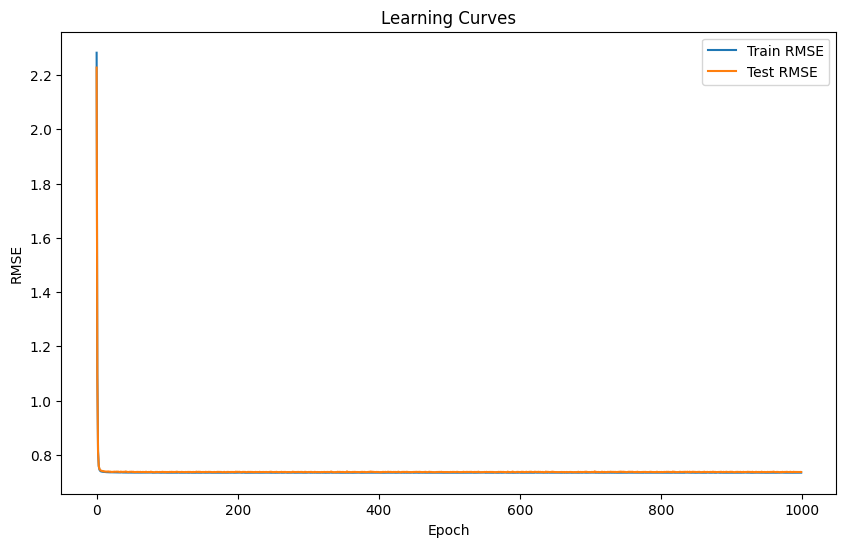

In [18]:
weights, bias, train_rmse_list, test_rmse_list = elastic_net_sgd_with_tracking(
    X_train_norm, y_train, X_test_norm, y_test, 
    lr=0.0001, lambda1=0.01, lambda2=0.01, epochs=1000
)

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_list, label='Train RMSE')
plt.plot(test_rmse_list, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()


### quick note
The learning curves show that both train and test RMSE drop sharply in early iterations and then stabilize around ~0.73, indicating fast convergence and good generalization. This result is much better than before because we used a smaller learning rate, shuffled data, and balanced regularization, preventing exploding weights. Unlike the earlier runs with large λ or unstable SGD, this setup finds a stable, well-fitted solution that balances bias and variance effectively.

In [19]:
# Hyperparamter optimization

def cross_val_rmse(X, y, lambda1, lambda2, lr=0.0001, epochs=300, k=5):
    n_samples = X.shape[0]
    fold_size = n_samples // k
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    rmse_list = []
    
    for fold in range(k):
        # Split indices
        val_idx = indices[fold * fold_size:(fold + 1) * fold_size]
        train_idx = np.setdiff1d(indices, val_idx)
        
        X_train_cv, y_train_cv = X[train_idx], y[train_idx]
        X_val_cv, y_val_cv = X[val_idx], y[val_idx]
        
        # Train model
        weights, bias, _, _ = elastic_net_sgd_with_tracking(
            X_train_cv, y_train_cv, X_val_cv, y_val_cv,
            lr=lr, lambda1=lambda1, lambda2=lambda2, epochs=epochs
        )
        
        # Compute validation RMSE
        y_val_pred = np.dot(X_val_cv, weights) + bias
        val_rmse = np.sqrt(np.mean((y_val_cv - y_val_pred) ** 2))
        rmse_list.append(val_rmse)
    
    return np.mean(rmse_list)


lambda1_list = [0, 0.001, 0.01]
lambda2_list = [0, 0.001, 0.01]

best_rmse = float('inf')
best_lambda1 = None
best_lambda2 = None

for l1 in lambda1_list:
    for l2 in lambda2_list:
        print(f"Testing lambda1={l1}, lambda2={l2}")
        avg_rmse = cross_val_rmse(X_train_norm, y_train, l1, l2)
        print(f"Avg CV RMSE: {avg_rmse:.4f}")
        
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_lambda1 = l1
            best_lambda2 = l2

print(f"\nBest combination: lambda1={best_lambda1}, lambda2={best_lambda2}, RMSE={best_rmse:.4f}")


Testing lambda1=0, lambda2=0
Epoch 0, Train RMSE: 2.7588, Test RMSE: 2.6506
Epoch 100, Train RMSE: 0.7366, Test RMSE: 0.7153
Epoch 200, Train RMSE: 0.7367, Test RMSE: 0.7147
Epoch 0, Train RMSE: 2.7608, Test RMSE: 2.8419
Epoch 100, Train RMSE: 0.7308, Test RMSE: 0.7402
Epoch 200, Train RMSE: 0.7306, Test RMSE: 0.7398
Epoch 0, Train RMSE: 2.7453, Test RMSE: 2.7716
Epoch 100, Train RMSE: 0.7285, Test RMSE: 0.7486
Epoch 200, Train RMSE: 0.7281, Test RMSE: 0.7492
Epoch 0, Train RMSE: 2.7551, Test RMSE: 2.7807
Epoch 100, Train RMSE: 0.7310, Test RMSE: 0.7387
Epoch 200, Train RMSE: 0.7310, Test RMSE: 0.7386
Epoch 0, Train RMSE: 2.7580, Test RMSE: 2.7478
Epoch 100, Train RMSE: 0.7349, Test RMSE: 0.7213
Epoch 200, Train RMSE: 0.7348, Test RMSE: 0.7211
Avg CV RMSE: 0.7325
Testing lambda1=0, lambda2=0.001
Epoch 0, Train RMSE: 2.7403, Test RMSE: 2.8145
Epoch 100, Train RMSE: 0.7325, Test RMSE: 0.7326
Epoch 200, Train RMSE: 0.7323, Test RMSE: 0.7327
Epoch 0, Train RMSE: 2.7436, Test RMSE: 2.7279
E

# Conclusion

The cross-validation results show that the best-performing combination was λ₁ = 0 and λ₂ = 0, achieving the lowest average RMSE of ~0.7325. This suggests that, in this case, adding L1 or L2 regularization did not improve performance, and the plain model without penalties fit the data best!